Running Genetic Algorithm...

Running Ant Colony Optimization...

------------------------
Algorithm Comparison
------------------------
Genetic Algorithm:
  Best Fitness Value Achieved: 602950
  Time Taken for Convergence (seconds): 0.8412742614746094

Ant Colony Optimization:
  Best Fitness Value Achieved: 564800
  Time Taken for Convergence (seconds): 13.717854499816895


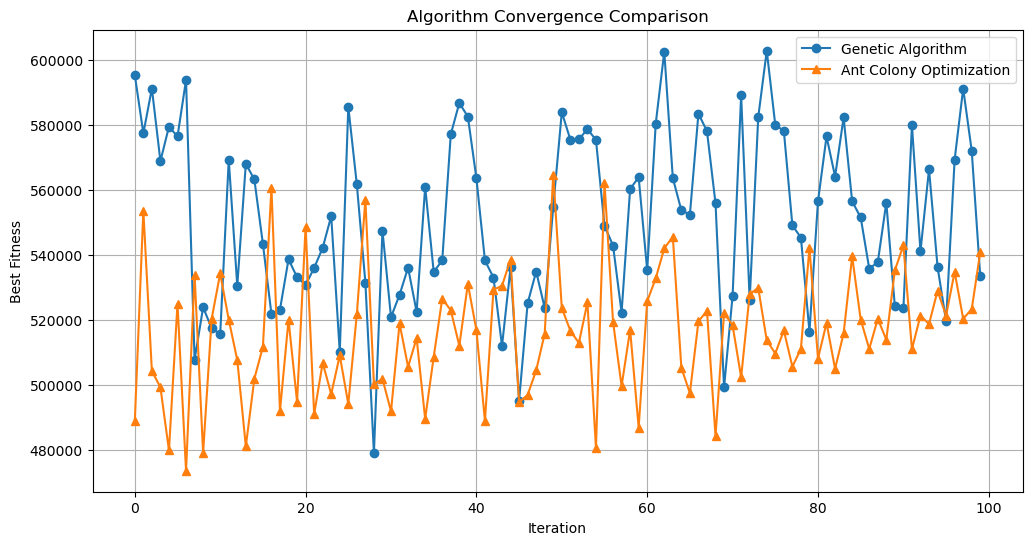


Best Solutions Found:
Genetic Algorithm:
Best solution:
Package 1 offers in Spring, Summer, Winter
Package 2 offers in Summer, Autumn, Winter
Package 3 offers in Spring, Autumn, Winter
Package 4 offers in Spring, Summer, Autumn, Winter
Package 5 offers in Spring, Summer, Winter
Package 6 offers in Spring, Summer, Autumn, Winter
Package 7 offers in Spring
Package 8 offers in Spring, Summer, Autumn
Package 9 offers in Spring, Summer
Package 10 offers in Spring, Summer, Autumn, Winter
Objective function value: 602950

Ant Colony Optimization:
Best solution:
Package 1 does not offer in any season
Package 2 offers in Spring, Summer, Winter
Package 3 offers in Spring, Summer, Autumn
Package 4 offers in Spring, Winter
Package 5 does not offer in any season
Package 6 offers in Spring, Summer, Autumn, Winter
Package 7 offers in Summer, Autumn
Package 8 offers in Winter
Package 9 offers in Spring, Autumn, Winter
Package 10 does not offer in any season
Objective function value: 564800


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# Define parameters including seasons
n = 10
m = 4  # Number of seasons
season_names = ['Spring', 'Summer', 'Autumn', 'Winter']  # Season names
c_i = np.array([200, 300, 100, 400, 500, 250, 150, 650, 350, 450])
c_k = np.array([20] * n)
p_i = np.array([450, 1750, 3400, 1950, 200, 4450, 500, 1200, 1100, 650])
b_r = 13000
R_k = np.array([100] * n)
r_ik = np.array([[10] * n] * m)  # Resource allocation for each package in each season
d_min_i = np.array([20, 30, 10, 40, 50, 25, 15, 65, 35, 110])
d_max_i = np.array([80, 90, 70, 120, 150, 100, 80, 200, 120, 130])
d_i = np.random.randint(0, 30, size=(n, m))  # Demand for each package in each season
MaxOfferingsPerSeason = 5  # Maximum number of offerings per season

# Genetic Algorithm parameters
population_size = 100
generations = 100
mutation_rate = 0.1

# Particle Swarm Optimization parameters
num_particles = 100
iterations_pso = 100
inertia_weight = 0.9
c1 = 2.0  # Cognitive parameter
c2 = 2.0  # Social parameter

# Ant Colony Optimization parameters
num_ants = 100
iterations_aco = 100
pheromone_decay = 0.1
pheromone_constant = 1.0

# Initialize pheromone matrix for ACO
pheromone_matrix = np.ones((n, m)) * pheromone_constant

# Define constraint functions
def resource_budget_constraint(selected_packages):
    total_cost = np.sum(np.dot(r_ik.T, selected_packages.T) * c_k)
    return total_cost <= b_r

def resource_constraint(selected_packages):
    total_resources = np.sum(np.dot(selected_packages, r_ik.T), axis=1)
    return np.all(total_resources <= R_k)

def demand_constraint(selected_packages):
    min_demand = np.dot(d_min_i, selected_packages)
    max_demand = np.dot(d_max_i, selected_packages)
    return min_demand <= max_demand

def binary_constraint(selected_packages):
    return np.all((selected_packages == 0) | (selected_packages == 1))

# Define seasonal constraints
def seasonal_constraints(selected_packages):
    return np.all(np.sum(selected_packages, axis=0) <= MaxOfferingsPerSeason)

def seasonal_package_offerings(selected_packages):
    for i in range(n):
        for j in range(m):
            if not is_package_suitable_for_season(i, j):
                selected_packages[i, j] = 0
    return selected_packages

def is_package_suitable_for_season(package_index, season_index):
    if package_index == 0 and (season_index == 1 or season_index == 2):
        return False
    return True

# Genetic Algorithm
def initialize_population():
    return np.random.randint(2, size=(population_size, n, m))

def evaluate_population(population):
    fitness_values = []
    for i in range(population_size):
        fitness_values.append(evaluate_solution(population[i]))
    return np.array(fitness_values)

def select_parents(population, fitness_values):
    parents = np.empty((2, n, m), dtype=int)
    for i in range(2):
        parent_index = np.random.choice(range(population_size))
        parents[i] = population[parent_index]
    return parents

def crossover(parents):
    crossover_point = np.random.randint(1, n)  # crossover point along the packages
    child1 = np.concatenate((parents[0][:crossover_point], parents[1][crossover_point:]), axis=0)
    child2 = np.concatenate((parents[1][:crossover_point], parents[0][crossover_point:]), axis=0)
    return child1, child2

def mutate(child):
    for i in range(n):
        for j in range(m):
            if random.random() < mutation_rate:
                child[i][j] = 1 - child[i][j]
    return child

def genetic_algorithm():
    start_time = time.time()
    population = initialize_population()
    generation_fitness = []
    best_solution = None
    best_fitness = float('-inf')

    for gen in range(generations):
        fitness_values = evaluate_population(population)
        generation_fitness.append(np.max(fitness_values))

        if np.max(fitness_values) > best_fitness:
            best_solution = population[np.argmax(fitness_values)]
            best_fitness = np.max(fitness_values)

        new_population = np.empty((population_size, n, m), dtype=int)
        for i in range(0, population_size, 2):
            parents = select_parents(population, fitness_values)
            child1, child2 = crossover(parents)
            new_population[i] = mutate(child1)
            if i + 1 < population_size:
                new_population[i + 1] = mutate(child2)

        population = new_population

    end_time = time.time()
    convergence_time = end_time - start_time

    return best_solution, generation_fitness, best_fitness, convergence_time


# Ant Colony Optimization
def select_next_package(pheromone_values, heuristic_values, selected_packages):
    probabilities = pheromone_values * heuristic_values
    probabilities[selected_packages == 1] = 0
    if np.sum(probabilities) == 0:
        return random.randint(0, n - 1)
    probabilities /= np.sum(probabilities)
    return np.random.choice(np.arange(n), p=probabilities)

def construct_solution():
    selected_packages = np.zeros((n, m), dtype=int)
    season_offerings_count = np.zeros(m, dtype=int)
    for ant in range(num_ants):
        for season in range(m):
            if season_offerings_count[season] < MaxOfferingsPerSeason:
                probability_threshold = 0.8
                if random.random() < probability_threshold:
                    current_package = select_next_package(pheromone_matrix[:, season], 1 / (c_i + 1), selected_packages[:, season])
                    if selected_packages[current_package, season] == 0:
                        selected_packages[current_package, season] = 1
                        season_offerings_count[season] += 1
            else:
                break
    return selected_packages

def evaluate_solution(selected_packages):
    total_profit = np.sum(p_i * np.sum(d_i * selected_packages, axis=1))
    total_cost = np.sum(np.dot(r_ik.T, selected_packages.T) * c_k)
    return total_profit - total_cost

def ant_colony_optimization():
    global pheromone_matrix  # Declare pheromone_matrix as global
    
    start_time = time.time()
    best_solution = None
    best_fitness = float('-inf')
    generation_fitness = []
    avg_fitnesses = []

    for iteration in range(iterations_aco):
        solutions = [construct_solution() for _ in range(num_ants)]
        solutions = [seasonal_package_offerings(solution) for solution in solutions]

        fitness_values = [evaluate_solution(solution) for solution in solutions]
        generation_fitness.append(fitness_values)

        if max(fitness_values) > best_fitness:
            best_solution = solutions[fitness_values.index(max(fitness_values))]
            best_fitness = max(fitness_values)

        pheromone_matrix *= (1 - pheromone_decay)
        for ant in range(num_ants):
            for season in range(m):
                for package in range(n):
                    if solutions[ant][package, season] == 1:
                        pheromone_matrix[package, season] += pheromone_constant / fitness_values[ant]

        avg_fitness = sum(fitness_values) / num_ants
        avg_fitnesses.append(avg_fitness)

    end_time = time.time()
    convergence_time = end_time - start_time

    return best_solution, generation_fitness, best_fitness, avg_fitnesses, convergence_time

# Comparison function
def compare_algorithms():
    # Run Genetic Algorithm
    print("Running Genetic Algorithm...")
    ga_best_solution, ga_generation_fitness, ga_best_fitness, ga_convergence_time = genetic_algorithm()

    # Run Ant Colony Optimization
    print("\nRunning Ant Colony Optimization...")
    aco_best_solution, aco_generation_fitness, aco_best_fitness, aco_avg_fitnesses, aco_convergence_time = ant_colony_optimization()

    # Compare and print results
    print("\n------------------------")
    print("Algorithm Comparison")
    print("------------------------")
    print("Genetic Algorithm:")
    print(f"  Best Fitness Value Achieved: {ga_best_fitness}")
    print(f"  Time Taken for Convergence (seconds): {ga_convergence_time}")

    print("\nAnt Colony Optimization:")
    print(f"  Best Fitness Value Achieved: {aco_best_fitness}")
    print(f"  Time Taken for Convergence (seconds): {aco_convergence_time}")

    # Plotting convergence
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(ga_generation_fitness)), [np.max(fitness) for fitness in ga_generation_fitness], label='Genetic Algorithm', linestyle='-', marker='o')
    plt.plot(range(len(aco_generation_fitness)), [np.max(fitness) for fitness in aco_generation_fitness], label='Ant Colony Optimization', linestyle='-', marker='^')
    plt.xlabel('Iteration')
    plt.ylabel('Best Fitness')
    plt.title('Algorithm Convergence Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Visualize best solutions found
    print("\nBest Solutions Found:")
    print("Genetic Algorithm:")
    print("Best solution:")
    for i in range(n):
        if np.any(ga_best_solution[i, :] == 1):
            offerings = [season_names[j] for j in range(m) if ga_best_solution[i, j] == 1]
            print(f"Package {i+1} offers in {', '.join(offerings)}")
        else:
            print(f"Package {i+1} does not offer in any season")
    print("Objective function value:", ga_best_fitness)

    print("\nAnt Colony Optimization:")
    print("Best solution:")
    for i in range(n):
        if np.any(aco_best_solution[i, :] == 1):
            offerings = [season_names[j] for j in range(m) if aco_best_solution[i, j] == 1]
            print(f"Package {i+1} offers in {', '.join(offerings)}")
        else:
            print(f"Package {i+1} does not offer in any season")
    print("Objective function value:", aco_best_fitness)

compare_algorithms()
